In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('all_data.csv', names =['label', 'headline'], encoding='latin-1')

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Quadro P6000'

In [5]:
sentences = df.headline.values

In [6]:
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]

In [7]:
df['label'] =df['label'].astype('category').cat.codes

In [8]:
labels = df.label.values

In [9]:
print(set(labels))

{0, 1, 2}


In [10]:
df.label.unique()

array([1, 0, 2], dtype=int8)

In [11]:
sentences[0]

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing . [SEP] [CLS]'

In [12]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['▁according', '▁to', '▁', 'gran', '▁', ',', '▁the', '▁company', '▁has', '▁no', '▁plans', '▁to', '▁move', '▁all', '▁production', '▁to', '▁', 'rus', 'sia', '▁', ',', '▁although', '▁that', '▁is', '▁where', '▁the', '▁company', '▁is', '▁growing', '▁', '.', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [13]:
MAX_LEN = 128

In [14]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [15]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [16]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [17]:
#Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=56, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=56, test_size=0.2)

In [18]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs, dtype=torch.long)
validation_inputs = torch.tensor(validation_inputs, dtype=torch.long)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [19]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [20]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=3)
model.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [21]:
# torch.save(model.state_dict(), directory_path+'/model_without_language_model.ckpt')
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    y_predict = []
    y_true_ = []
    for i, batch in enumerate(validation_dataloader):
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Forward pass
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      # print (outputs)
      prediction = torch.argmax(outputs[0],dim=1)
      total += b_labels.size(0)
      correct+=(prediction==b_labels).sum().item()
    
      y_predict.append(prediction)
      y_true_.append(b_labels)

In [22]:
print('Test Accuracy of the model on vla data is: {} %'.format(100 * correct / total))


Test Accuracy of the model on vla data is: 43.1958762886598 %


In [23]:
y_pred = [item for sublist in y_predict for item in sublist]
y_true = [item for sublist in y_true_ for item in sublist]

In [24]:
y_pred = [x.cpu().numpy() for x in y_pred]
y_true = [x.cpu().numpy() for x in y_true]

In [25]:
from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.16      0.56      0.24       116
     neutral       0.64      0.61      0.62       580
    positive       0.33      0.00      0.01       274

    accuracy                           0.43       970
   macro avg       0.38      0.39      0.29       970
weighted avg       0.50      0.43      0.40       970



In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[ 65,  51,   0],
       [225, 353,   2],
       [125, 148,   1]])

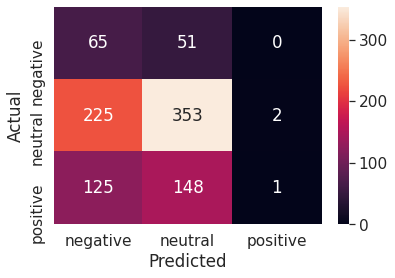

In [27]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, target_names, target_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt='d') # font size

plt.show()